# EDA
### Jumbo Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import the libraries

In [ ]:
!pip install emoji

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.filterwarnings("ignore")

### Import the data set

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/datasets/jumbo-data.xlsx")

In [ ]:
df.head()

,Case Number,Case Description,Case Origin
0,3349414.0,Mijn vrouw had wat van deze noten in haar kwar...,Web
1,4438158.0,klacht over baas en bazin winkel.,Phone
2,4561261.0,"Dag, ik had een probleem met mijn bestelling v...",WhatsApp
3,4378916.0,Beste heer mevrouw Inmiddels zijn we 3 maanden...,WhatsApp
4,4438325.0,"Hallo, staan er voedingswaarden vermeld op de ...",WhatsApp


In [ ]:
# rename the columns for easy typing
df.rename(columns={"Case Number": "id", "Case Description": "descr", "Case Origin": "source"}, inplace=True)

## Data Profiling

In [ ]:
df.shape

(95922, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95922 entries, 0 to 95921
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      95913 non-null  float64
 1   descr   95917 non-null  object 
 2   source  95913 non-null  object 
dtypes: float64(1), object(2)
memory usage: 2.2+ MB


In [ ]:
# check for duplicates in the 'descr' column
duplicates = df.duplicated(subset=["id" ,"descr"])
print("Number of duplicates:", duplicates.sum())

Number of duplicates: 7350


In [ ]:
df.isnull().sum()

id        9
descr     5
source    9
dtype: int64

In [ ]:
# create a boolean mask of null values
mask = df.isnull().any(axis=1)

# select the rows that have at least one null value
rows_with_null = df[mask]

# print the selected rows
print(rows_with_null)

              id                                              descr  source
27726  4503153.0                                                NaN  E-mail
60314        NaN  ? 1070 Bruxelles / Brussel [cid:image002.png@0...     NaN
92512        NaN                                                NaN     NaN
92513        NaN  Here you can find the after-movie of last year...     NaN
92514        NaN                                                NaN     NaN
92515        NaN  Best regards, Florian Hello Jumbo Marketing Te...     NaN
92516        NaN                                                NaN     NaN
92517        NaN  Here you can find the after-movie of last year...     NaN
92518        NaN                                                NaN     NaN
92519        NaN  Best regards, Florian Hi you're chatting with ...     NaN


In [ ]:
data = df.dropna()

In [ ]:
data.shape

(95912, 3)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95912 entries, 0 to 95921
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      95912 non-null  float64
 1   descr   95912 non-null  object 
 2   source  95912 non-null  object 
dtypes: float64(1), object(2)
memory usage: 2.9+ MB


In [ ]:
data["source"].unique()

array(['Web', 'Phone', 'WhatsApp', 'E-mail', 'Telefoon', 'Twitter',
       'Letter', 'Facebook', 'Customer - Chat'], dtype=object)

### Visualize from which source are the most ocurring queries.

<Axes: xlabel='source', ylabel='count'>

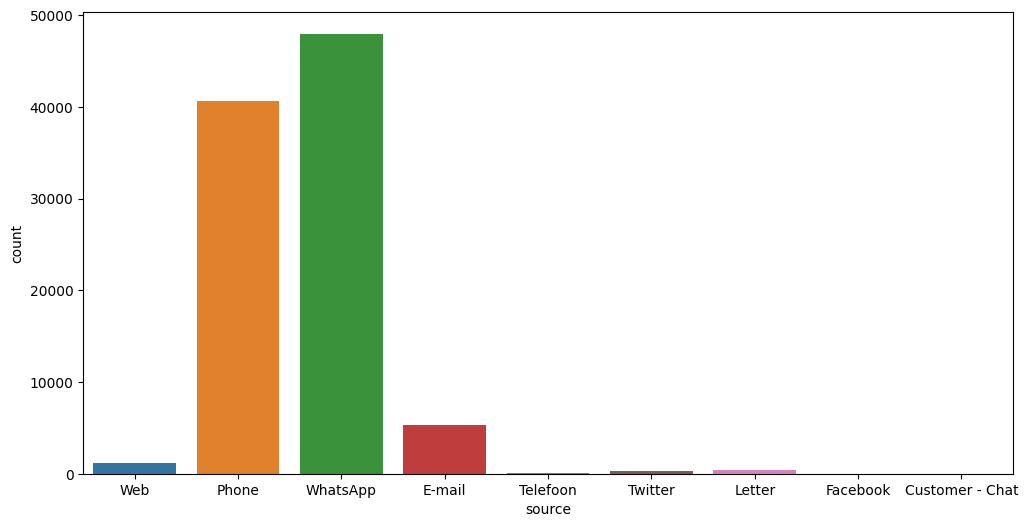

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x="source", data=data)

In [ ]:
counts = data["source"].value_counts()
counts

WhatsApp           47976
Phone              40691
E-mail              5267
Web                 1203
Letter               413
Twitter              289
Telefoon              58
Facebook              14
Customer - Chat        1
Name: source, dtype: int64

### Explore the text distribution

In [ ]:
data["text_length"] = data["descr"].astype(str).apply(len)
data["text_word_count"] = data["descr"].apply(lambda x: len(str(x).split()))

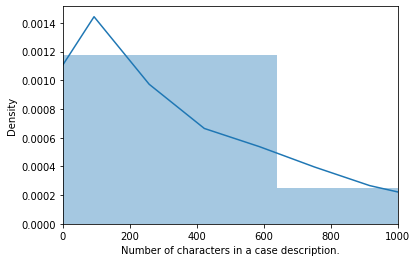

In [ ]:
# plot the length of the characters in a case query
sns.distplot(data["text_length"])
plt.xlim([0, 1000]);
plt.xlabel("Number of characters in a case description.");

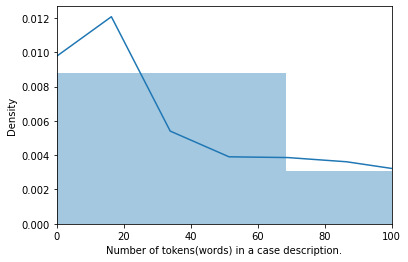

In [ ]:
# plot the number of words in a case query
sns.distplot(data["text_word_count"])
plt.xlim([0, 100]);
plt.xlabel("Number of tokens(words) in a case description.");

### Explore the cases per `Web source`

In [ ]:
# select the cases which are coming from the 'Web'
web_cases = data[data.source.isin(["Web"])]
web_cases["descr"].head(25)

0      Mijn vrouw had wat van deze noten in haar kwar...
5      Beste Jumbo, wij zijn al heel lang klant bij h...
15     Gisteravond is een hele krat met boodschappen ...
25     Goedemorgen. Ik had een paar weken geleden bes...
50     Ik heb ruim 20 minuten moeten wachten voordat ...
155    Het tijdstip van bezorging zou tussen 8.00 en ...
175    Beste, Bij mijn online bestelling had ik Oedip...
235    Deze klant heeft een terugbetaling van statieg...
263    Deze klant heeft een terugbetaling van statieg...
294    Deze klant heeft een terugbetaling van statieg...
527    Deze klant heeft een terugbetaling van statieg...
544    Deze klant heeft een terugbetaling van statieg...
553    Deze klant heeft een terugbetaling van statieg...
620    Ik koop regelmatig de Jumbo XL inlegkruisjes. ...
630    Ik heb een tijd geleden kontakt gehad met de k...
645    Jumbo had actie van leeuwenzegel frituurvet 50...
665    Deze klant heeft een terugbetaling van statieg...
695    Smelt chocolade melk jum

In [ ]:
web_cases["descr"][0]

'Mijn vrouw had wat van deze noten in haar kwark gedaan en beet vervolgens bijna haar kies kapot! Normaal valt dit wel op maar omdat het nu in de kwark zat viel niet niet op.'

In [ ]:
web_cases["descr"][553]

'Deze klant heeft een terugbetaling van statiegeld aangevraagd voor: 1 x Jumbo boodschappenkrat. Unitprijs: 5 EUR. Totale prijs: 5 EUR. 4 x lege fles frisdrank. Unitprijs: 0.25 EUR. Totale prijs: 1.00 EUR. 3 x Plastic fles 0,25L - 0,5L. Unitprijs: 0.15 EUR. Totale prijs: 0.45 EUR. 1 x volle krat bier 18/24 fles / campina. Unitprijs: 3.9 EUR. Totale prijs: 3.9 EUR. 1. Doe een terugbetaling voor deze artikelen op statiegeldartikelen (géén producten) met dezelfde prijs in de huidige bestelling. 2. Voor artikelen die niet in de huidige bestelling zitten, doe een terugbetaling op statiegeldartikelen (géén producten) met dezelfde prijs in een eerdere bestelling. 3. Maak een GOGW aan voor de resterende statiegeldartikelen. 4. Stuur een handmatige ipv automatische e-mail naar de klant om uit te leggen hoe ze hun geld terugkrijgen.'

In [ ]:
web_cases["descr"][810]

'Bestelnummer 6029494884: bestelkosten ten onrechte in rekening gebracht. Mvg Alie Kleinhaarhuis'

### Explore the cases per `Phone source`

In [ ]:
# select the cases which are coming from the 'Phone'
phone_cases = data[data.source.isin(["Phone"])]
phone_cases["descr"].head(25)

1                     klacht over baas en bazin winkel.
9     Kredietlimiet ?1.00 Bestedingsruimte ?-25.02 8...
10    bezorger door de heg gereden. mail gestuurd. 1...
13                       Klant belt wacht op bestelling
18    Klant belt, bestelling is vertraagd maar heeft...
20                 belt over een bestelling van vandaag
23                 klant heeft verkeerde krat ontvangen
24            Klant had een terug betaling aangevraagd,
28    Klant belt vraag is waarom de Remis fritesaus ...
29          Vragen over pas en account en punten sparen
30                             betalingslimiet verhogen
31    wij zijn een stichting en andere lokaties hebb...
33    kl geeft aan dat haar account geblokkeerd is d...
37    Kl wilde weten hoe ze de bestelling moest beta...
39                       vraagt waar de bezorger blijft
40    bestelling komt 5u maar kl kan niet thuis zijn...
41    Klant belde en gaf aan dat ze zich bijna heeft...
44        vraag of haar bestelling goed is doorg

In [ ]:
phone_cases["descr"][9]

'Kredietlimiet ?1.00 Bestedingsruimte ?-25.02 8010446 klopt het dat dit bedrag nog openstaat en zo ja met welke gegevens kan ik de klant deze laten overmaken ?'

In [ ]:
phone_cases["descr"][18]

'Klant belt, bestelling is vertraagd maar heeft boodschappen echt z.s.m. nodig. Collega zou hebben gezegd dat een volgende bezorger dit oplost? Aangegeven dat de bezorger het niet kon vinden maar terug rijdt. Wil notitie laten maken dat als ze tussen 8 en 10 levering besteld, het dan ook geleverd wordt. Klant belt weer is nog steeds niet bezorgd'

In [ ]:
phone_cases["descr"][28]

'Klant belt vraag is waarom de Remis fritesaus Classic 1000ml het emmertje uit het online assortiment is'

### Explore the cases per `WhatsApp source`

In [ ]:
# select the cases which are coming from the 'Phone'
whapp_cases = data[data.source.isin(["WhatsApp"])]
whapp_cases["descr"].head(25)

2     Dag, ik had een probleem met mijn bestelling v...
3     Beste heer mevrouw Inmiddels zijn we 3 maanden...
4     Hallo, staan er voedingswaarden vermeld op de ...
6     Bij Bestelling: 6057976661 had ik een servicec...
7     Hi! Ik heb mijn bestelling net ontvangen. Ik h...
8     Hello, is it possible to have this conversatio...
11    Hallo ik wil even door geven dat ik morgen een...
12    Hallo Jumbo! Ik probeer artikelen aan mijn bes...
14    Goedenmiddag. Ik had 4 repen verkade besteld 1...
16    Best Jumbo, ik heb nog geen terug betaling ont...
17    Goede morgen ik wacht als sinds 8:00 op mijn b...
19    Hoi Wij missen een aantal producten bij onze b...
21    Goedemiddag, de app geeft geen besteltijd meer...
22    Goedenavond, het is al niet meer nodig, ze hee...
26    Ik ben klaar met mijn boodschappenlijst maar e...
27    Volgens mij zitten de gratis producten er niet...
32    Hallo, ik probeer al een tijdje een online bes...
35    Goedendag, ik ben benieuwd waar ik mijn nr

In [ ]:
whapp_cases["descr"][2]

'Dag, ik had een probleem met mijn bestelling van 14/2/23 gemeld. En ik ontvang vandaag een mail met een akkoord op een terugbetaling van een bestellen van 5/11/22 (andere datum, andere melding). Denk dat er iets niet goed gaat?? Hallo Antoinette , je chat met Rubin. Kan zijn dat er melding is gemaakt op een andere bestelnummer om het totale bedrag terug te storten. Maar heb je een screenshot? Dan kan ik met je meekijken, ik hoor graag van je. Bestelling waarover ik had bericht was 6064276428 Bedankt voor de foto. Volgens het systeem is te zien dat er een fout is gemaakt met de datum.Het gaat om hetzelfde bedrag 😊. Ik hoop je voldoende te hebben geinformeerd. Fijne avond!'

In [ ]:
whapp_cases["descr"][3]

'Beste heer mevrouw Inmiddels zijn we 3 maanden verder en heb ik nog steeds geen race auto ontvangen. Duurt nu wel weg lang Hoop hem toch snel te ontvangen Mvg Daniëlle'

In [ ]:
whapp_cases["descr"][4]

'Hallo, staan er voedingswaarden vermeld op de flessen wijn die u verkoopt? Hallo, je chat met Sharon. Bedankt voor je bericht. Nee, niet volledig. Je kan dit navragen in de winkel en anders kunnen wij dit voor je opzoeken. Fijne dag. 😊 Ok bedankt, jij ook een fijne dag! Groetjes Greet Dankjewel!'

In [ ]:
whapp_cases["descr"][6]

'Bij Bestelling: 6057976661 had ik een servicecode ingevuld voor 5 euro korting tegen inlevering van 1000 punten. Deze 5,00 staat niet op de bon vermeld, is er niet getrokken terwijl deze bij het totaal verkregen korting wel is meegeteld. Laat maar, ik zie net dat het in het totaal wel te zien is. Het staat er alleen niet apart op vermeld. Oke toppie👍. Fijne dag.'

In [ ]:
whapp_cases["descr"][8]

"Hello, is it possible to have this conversation in english? Hello! I have made a refund request on Jumbo. I would like to cancel it as the delivery man came back and brought the missing items within an hour. I could not find out how to do that as I have difficulty translating the website into english Hello your chat with Raffaela. Good of you to send a message. Do you have an order number for me? Yes just a minute! 6058655116 this is the order number for the order :) by the way, will I get any points from this order? Okay let's get it out. Have a nice evening"

In [ ]:
whapp_cases.isnull().sum()

id        0
descr     0
source    0
dtype: int64

### Explore the cases per `E-mail source`

In [ ]:
# select the cases which are coming from the 'Phone'
email_cases = data[data.source.isin(["E-mail"])]
email_cases["descr"].head(25)

34     Is deze mailing niet goed leesbaar? Bekijk de ...
48     Hallo Ik koop altijd bij Jumbo (Udenhout) mijn...
63     Goedemiddag, Ik heb daarnet een mailtje gestuu...
77     Goedemiddag, Uw betaald de verkeerde ordernumm...
104    Beste Jumbo Zeker fijn dat jullie deze informa...
141    Hoezo kan ik het pas zaterdagavond ophalen. Ma...
146    Geachte heer/mevrouw, Zojuist al een mail gest...
148    Claudia Kleinherenbrink Industrieweg 10 ? 5281...
214    Lekker op tijd! Hij is al op Met vriendelijke ...
236    Van: Bianca Meerkerk <bianca_meerkerk@hotmail....
273    Geachte, Ik.heb nog niks ontvangen. Kunt u het...
274    [cid:image001.png@01D92C27.26DE2660] Beselare,...
277    *via niv2 inbox* Van: i.p.n.van_tilburg@lumc.n...
283    Goedemorgen, Kan het zo zijn dat ik dit bedrag...
308    Al voldaan!! Verzonden vanaf mijn Galaxy -----...
309    L.S., vanmiddag hadden wij op ons vakantiemenu...
315    [Microsoft]<https://products.office.com> Bekij...
325                         Bij

In [ ]:
email_cases["descr"][34]

'Is deze mailing niet goed leesbaar? Bekijk de mailing in uw browser<https://mailchi.mp/vadelo/verpakkingsmateriaal-direct-leverbaar-441862?e=5efbb5638f> [https://gallery.mailchimp.com/8f8fef41f06e12b3f9d1e70f7/images/c41480a8-4b7b-4a61-b467-c3b74ec1cc27.jpg]<https://officepalace.us3.list-manage.com/track/click?u=8f8fef41f06e12b3f9d1e70f7&id=060180fac3&e=5efbb5638f> [https://mcusercontent.com/8f8fef41f06e12b3f9d1e70f7/images/1694ef67-db6b-f9ad-15dd-d6981514d057.png]<https://officepalace.us3.list-manage.com/track/click?u=8f8fef41f06e12b3f9d1e70f7&id=8a2caa959a&e=5efbb5638f> Beste relatie, Vanuit de markt merken wij vanuit Vadelo een verhoogde vraag naar zelftesten. Momenteel hebben wij nog voldoende op voorraad. Vadelo levert direct uit eigen import, daardoor bieden we dus altijd de laagste prijs. Gebruiksvriendelijke speekseltesten en neustesten: - FlowFlex Single pack NL ? 529.965 op voorraad - FlowFlex Single pack EN ? 24.038 op voorraad - FlowFlex 5-pack ? 21.682 op voorraad - FlowF

In [ ]:
email_cases["descr"][48]

'Hallo Ik koop altijd bij Jumbo (Udenhout) mijn verspakket om lasagne te maken, omdat deze erg lekker is. Echter: De laatste keer zaten er 8 ipv 9 lasagnebladen in. Ik ging ervan uit dat dit een vergissing was. Maar helaas ook nu weer een pakket met maar 8 lasagnebladen. Dat is vervelend, want je hebt 3 lagen van 3 bladen nodig. Is dit een vergissing of verandering van samenstelling in het pakket? In het laatste geval zal ik gaan overstappen naar een ander merk/winkel. Ik zie graag uw reactie tegemoet. J v Wijk Verzonden vanaf mijn Galaxy'

In [ ]:
email_cases["descr"][274]

'[cid:image001.png@01D92C27.26DE2660] Beselare, 09-01-2023 ?Betreft; Verzoek om prijzen in natura ? ? Geachte , Onze excuses dat we jou beroven van uw kostbare tijd. Maar alvast van harte dank om deze mail even te lezen. Als organisator van de werkgroep ?The Flaming Darters ?, die zich bezighoudt met het organiseren van hun 2de Dartstornooi binnen Groot-Zonnebeke. Dit betreft een tornooi dat doorgaat op 25 maart 2023. Deze worden dan ook voor verschillende groepen ingedeeld, voor Heren, Dames en Junioren. Ons tornooi is nu al volledig volzet, mede door de hype die het darten kent. Van de Belgische toppers, TV, WK. Wat inhoudt dat er 96 heren, 32 dames en 16 junioren ingeschreven zijn. Afkomstig uit het hele Vlaamse land. Dit mede door de bekendmaking bij verschillende clubs uit Oost- & West Vlaanderen. Daarom zouden we heel graag een mooie tombola op de dag zelf willen organiseren. Uiteraard is het de bedoeling om zoveel mogelijk deelnemers te belonen met een mooie prijs. Bij dezen zou

In [ ]:
email_cases["descr"][315]

'[Microsoft]<https://products.office.com> Bekijk deze berichten 1 berichten worden voor u bewaard om te bekijken vanaf 21-2-2023 03:11:25 (UTC) . Bekijk ze binnen 15 dagen na de datum van ontvangst door naar de pagina Quarantaine<https://security.microsoft.com/quarantine> te gaan in het beveiligings- en compliancecentrum. Spamberichten zijn voorkomen Afzender: no-reply@sharepointonline.com Onderwerp: _Jumbo Document Datum: 21-2-2023 02:08:19 Bericht controleren <https://security.microsoft.com/quarantine?id=96f0db5a-9802-4d46-1247-08db13b0806e\\b6111630-9445-51c1-e4e6-1bc33977cca1&recipientAddress=%40ENC%40KDQ26mJtyCdo49DKW78IyNPVZ8%2FTNmBV0ovnTmvk7rjIGiXrDamb90pjVnjE9BfdRkp5%2BCvhmMCsxzoJLmOzcfPDRl0wGiIkghdemq%2BDmko%3D> Vrijgeven <https://eur03-quarantine.dataservice.protection.outlook.com/spamdigestesn/spamdigest.svc/releasespam/orgs/862dec83-e43a-4c95-aed3-8e98e6038d5f/users/klantenservice@jumbo.com/mail/96f0db5a-9802-4d46-1247-08db13b0806e?token=fwKejiuCFKf%2b59sFvrN8BEEGL4ypQ6xaJX